# Notebook pour apprendre à recaler les tumeurs

In [6]:
from __future__ import print_function
import sys
import os
import logging
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics
%config Completer.use_jedi = False
import SimpleITK as sitk
import nibabel as nib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import logging
import cv2
import scipy.ndimage as nd
from natsort import natsorted
from utils import get_all_good_slices, give_ls, get_good_slice, rescale_image, rescale_image_float, mask_superpose_simple, check_key_num, resample_image_to_reference
from utils_recaler import equalize_slices, shift_horizontal_with_zeros, shift_vertical_with_zeros, move, calc_ps, calc_ps_decal, find_best_decal, find_best_z_decal, find_best_decal_all_times, eliminate_temps

### Print pour une slice les temps côté à côte

In [7]:
time_inj = ["_ART", "_PORT", "_VEIN","_TARD"]

ls_image =sorted(glob.glob('./*_NAT*/*.nii'))
print(ls_image[1])
ls_image_no_time = natsorted(list(set([eliminate_temps(x) for x in ls_image])))
ls_image_full_times_surconfiance = [[name +time + ".nii" for time in time_inj] for name in ls_image_no_time]
ls_image_full_time = []
dict_image_full_time = {}
for li_names in ls_image_full_times_surconfiance:
    li_true_names = []
    for i,name in enumerate(li_names):
        if name in ls_image:
            li_true_names.append(name)
    ls_image_full_time.append(li_true_names)
    classe_name = li_names[0].split('/')[-2].split('_')[1]
    patient_num = li_names[0].split('/')[-1].split('_')[0]
    dict_image_full_time[(patient_num, classe_name)] = li_true_names


./Dataset_CCK_NAT/10_PORT.nii


In [8]:
def show_all_time(num = None, key = None, slices = None, li_mask_external = None):
    names = check_key_num(num, key, ls_image_full_time, dict_image_full_time)
    if slices == None:
        slices = [get_good_slice(image_name = names[0]) for name in names] #sort la même slice que la première à chaque fois
    if li_mask_external == None:
        li_mask_external = [None for name in names]
    size = len(names)
    plt.subplots(1, size, figsize = (size*10, 10))
    for i,name in enumerate(names):
        mask_superpose_simple(name, slice_num = slices[i], other_mask = li_mask_external[i], num = i+1, max_num = size, legend = name.split('/')[-2].split('_')[1] + "_" + name.split('/')[-1].split('.')[0])
        
        
    
    

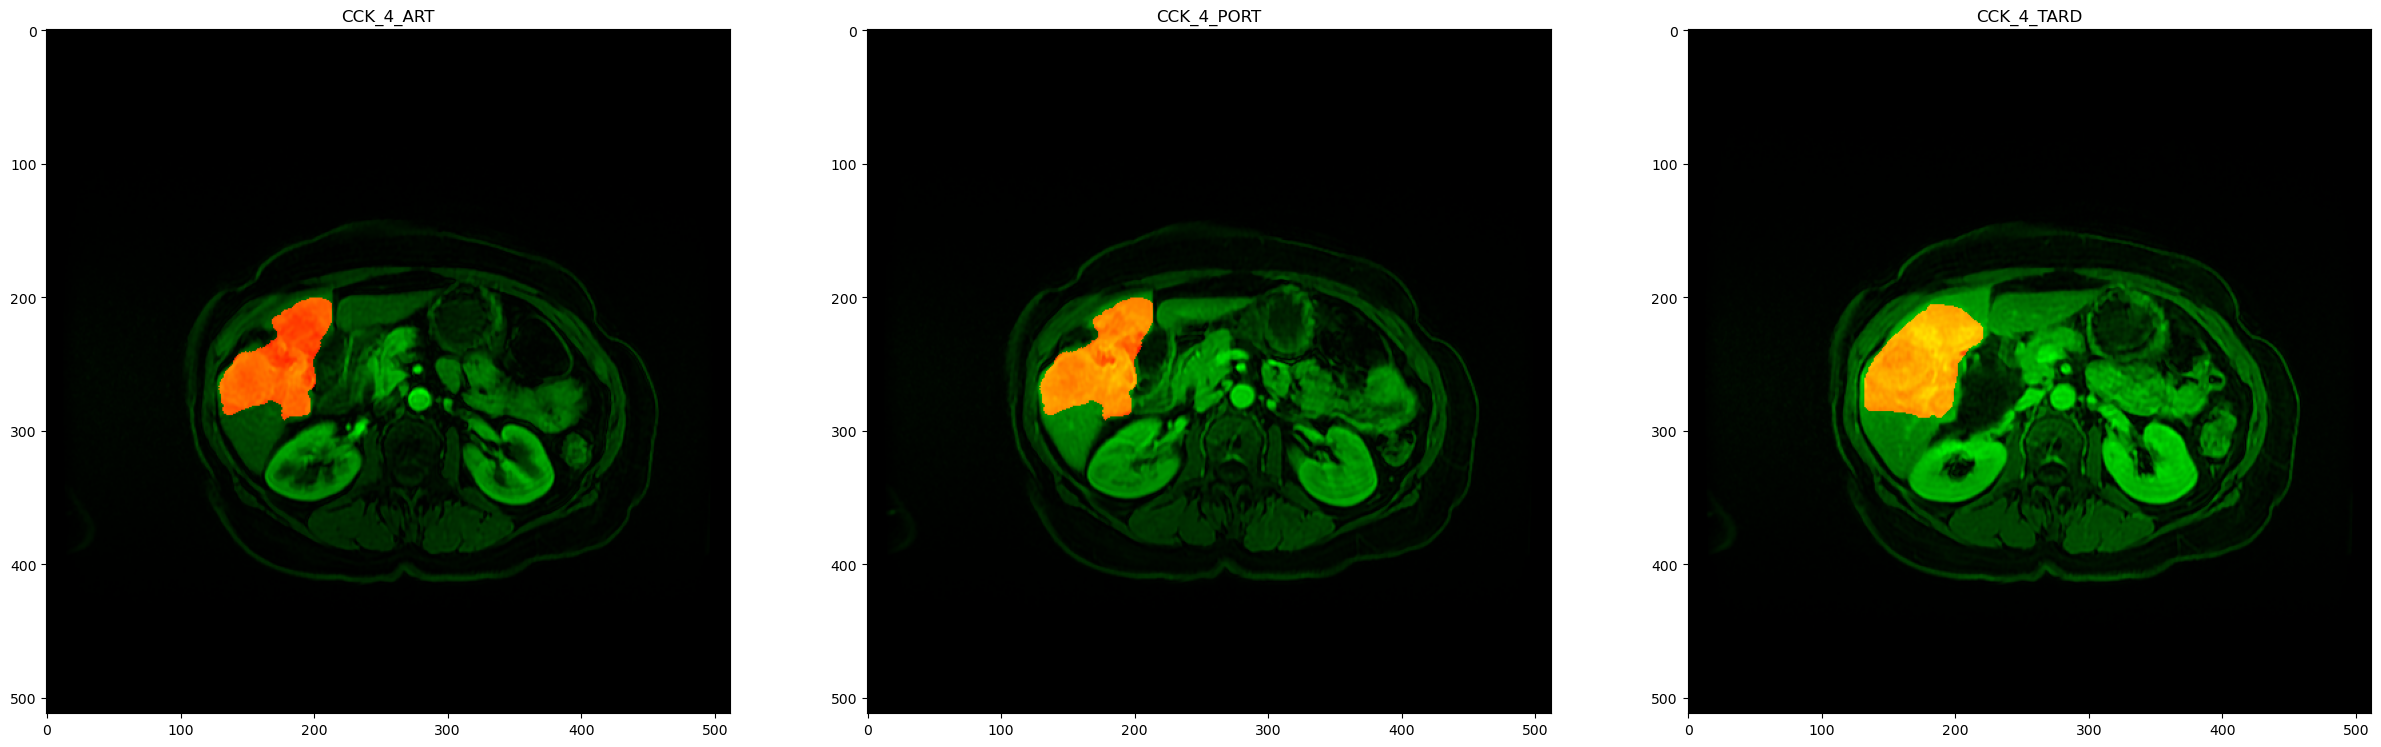

In [9]:
show_all_time(num = 3)

### Gérer les déséquilibres en nombre de slices de masque et translater le masque

In [10]:
find_best_decal_all_times(ls_image_full_time, dict_image_full_time,num = 1, mode = "area")

[0, 0, 0, 1]

In [16]:
for num in range(len(ls_image_full_time)):
    names = check_key_num(num,None, ls_image_full_time, dict_image_full_time)
    li_dims_images = [np.array(list(sitk.ReadImage(name).GetSize()))*np.array(list(sitk.ReadImage(name).GetSpacing())) for name in names]
    names_masks = [name.replace('_NAT','').replace('.nii','_masked.nii') for name in names]
    li_masks = [(sitk.ReadImage(name_mask) !=0) for name_mask in names_masks]
    li_num_slice_tot = np.array([mask.GetSize()[2] for mask in li_masks])
    reference = max(li_num_slice_tot)
    differences = reference - li_num_slice_tot
    if sum(differences) > 0:
        print(num,names, differences, "dimensions", li_dims_images)
        

1 ['./Dataset_CCK_NAT/2_ART.nii', './Dataset_CCK_NAT/2_PORT.nii', './Dataset_CCK_NAT/2_VEIN.nii', './Dataset_CCK_NAT/2_TARD.nii'] [ 0  0  0 72] dimensions [array([380.00640869, 380.00640869, 200.00019073]), array([380.00640869, 380.00640869, 200.00019073]), array([380.00640869, 380.00640869, 200.00019073]), array([380.00640869, 380.00640869, 196.00021362])]
15 ['./Dataset_CCK_NAT/17_ART.nii', './Dataset_CCK_NAT/17_PORT.nii', './Dataset_CCK_NAT/17_TARD.nii'] [40  0  0] dimensions [array([420.        , 420.        , 136.03161621]), array([400. , 312.5, 224. ]), array([400. , 312.5, 224. ])]
31 ['./Dataset_CHC_NAT/18_ART.nii', './Dataset_CHC_NAT/18_PORT.nii', './Dataset_CHC_NAT/18_VEIN.nii', './Dataset_CHC_NAT/18_TARD.nii'] [0 0 0 8] dimensions [array([351.    , 285.1875, 240.    ]), array([351.    , 285.1875, 240.    ]), array([351.    , 285.1875, 240.    ]), array([351.    , 285.1875, 216.    ])]
33 ['./Dataset_CHC_NAT/20_ART.nii', './Dataset_CHC_NAT/20_PORT.nii', './Dataset_CHC_NAT/20_

71
[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
[49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
(512, 512, 96)
(512, 512, 96)
(512, 512, 96)


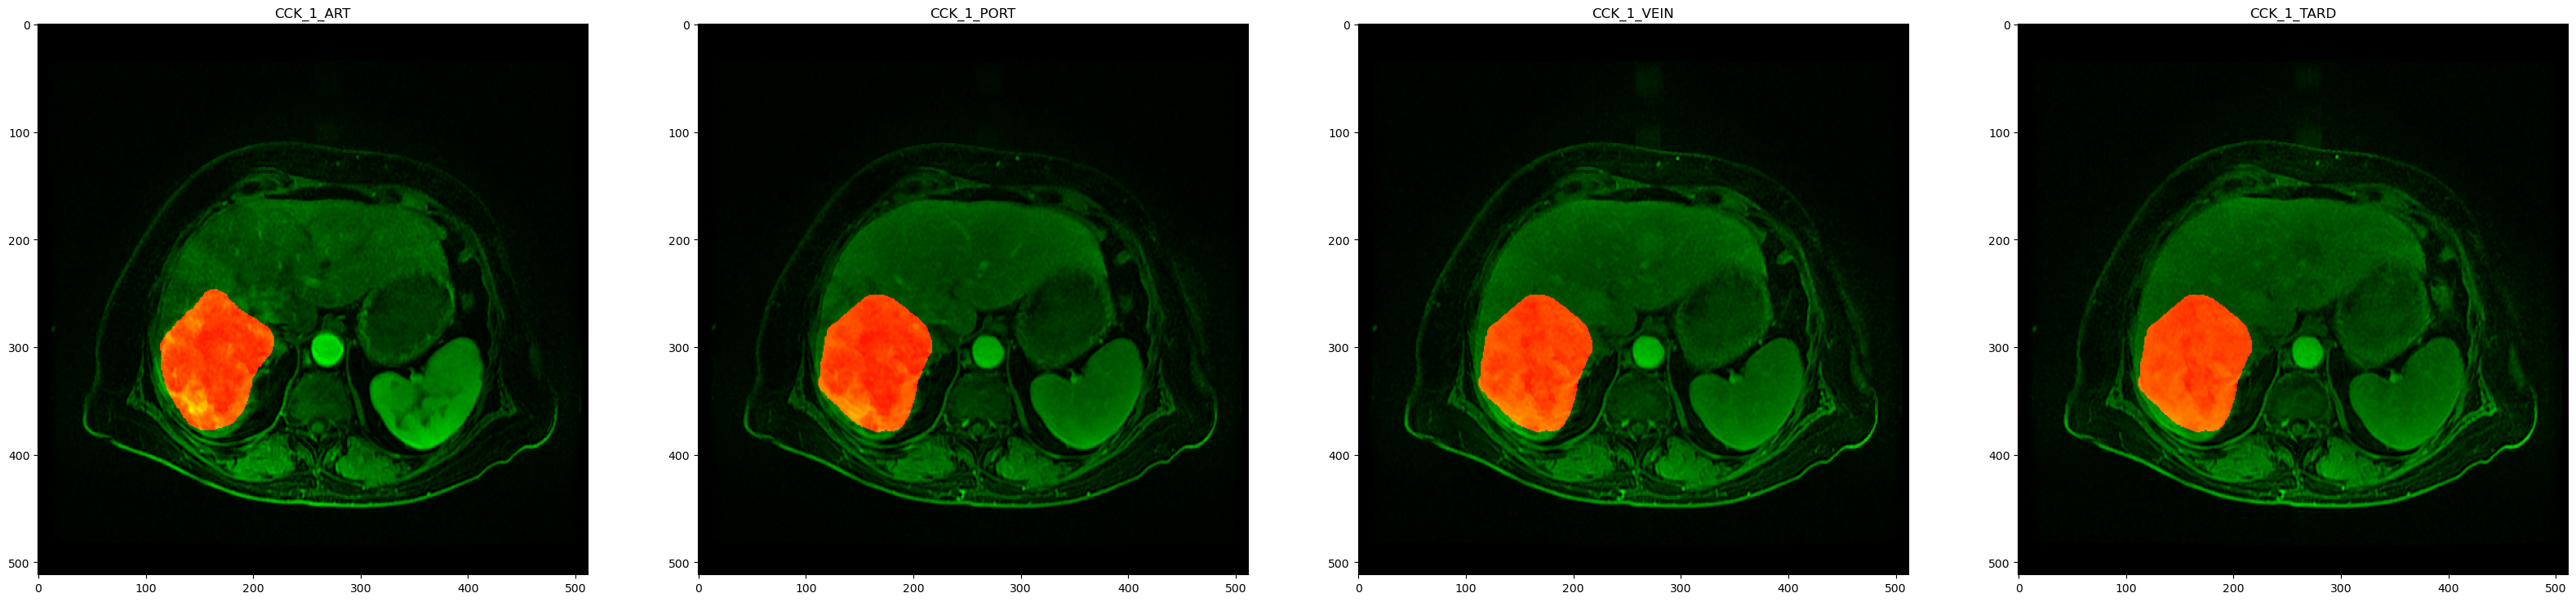

In [20]:
num = 0
slice_ref = get_good_slice(image_name = ls_image_full_time[num][1])
print(slice_ref)
print(get_all_good_slices(image_name = ls_image_full_time[num][0]))
print(get_all_good_slices(image_name = ls_image_full_time[num][1]))
print(get_all_good_slices(image_name = ls_image_full_time[num][2]))
show_all_time(num = num, slices = [slice_ref, slice_ref + 1, slice_ref + 1, slice_ref + 1])
print(sitk.ReadImage(ls_image_full_time[num][0]).GetSize())
print(sitk.ReadImage(ls_image_full_time[num][1]).GetSize())
print(sitk.ReadImage(ls_image_full_time[num][2]).GetSize())


